In [1]:
import glob
import matplotlib.pyplot as plt
import numpy as np
import os
import matplotlib.patches as patches
from matplotlib.patches import Rectangle, Circle
from scipy.ndimage import rotate, zoom
from astropy.io import fits
from astropy.visualization import wcsaxes
from astropy.wcs import WCS
import astropy.visualization as ax
from astropy.coordinates import SkyCoord, SpectralCoord
import astropy.units as u
from photutils.detection import DAOStarFinder
from astropy.visualization import SqrtStretch
from astropy.visualization.mpl_normalize import ImageNormalize
from photutils.aperture import CircularAperture, aperture_photometry
from microfilm import colorify, microplot
from skimage import exposure
import scipy.optimize as opt
from mpl_toolkits.mplot3d import axes3d
from photutils.datasets import make_4gaussians_image
from photutils.centroids import (centroid_1dg, centroid_2dg,
                                 centroid_com, centroid_quadratic)
from mpl_toolkits.axes_grid1.inset_locator import (mark_inset, zoomed_inset_axes)
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
from tqdm import tqdm

In [2]:
from matplotlib import rcParams
rcParams['font.sans-serif'] = ['Times']
rcParams['pdf.use14corefonts'] = True
rcParams['font.family'] = 'serif'
#rcParams['text.usetex'] = True
#rcParams['ps.useafm'] = True
rcParams['font.size'] = 8
rcParams['mathtext.fontset'] = 'cm'
%matplotlib ipympl

# Functions

$\texttt{channel\_plot}$ is a function that display the image corresponding to a particular channel/wavelength of the cube.

$\texttt{some\_channels\_plot}$ display the image obtained after summing some interval of channels, which is interesting
on account of an emission line does not fall in a single channel but it is a gaussian distribution that
includes few channels.

$\texttt{spectroscopy\_notshowing}$ obtains the spectrum of a region given the center pixel in each spatial direction.

$\texttt{spectroscopy\_showing\_rectangle}$, in addition to obtain the spectrum, it displays an auxiliar plot to see which is the 
region whose spectrum we are extracting


In [3]:
def channel_plot(master_cube, channel, vmax):
    # Wavelength in microns
    lambda_value = wcs_half2.spectral.pixel_to_world(channel).to(u.um)

    # BE CAREFUL: IN DS9 THE CHANNELS STARTS IN 1 BUT THE PYTHON INDEXES STARTS IN 0,
    # SO IF WE'RE GOING TO COMPARE OUR RESULTS WITH DS9, IN DS9 WE MUST TAKE CHANNEL+1
    
    # Make the plot
    plt.figure()
    ax = plt.subplot(projection=wcs_half2.celestial) 
    plt.imshow(master_cube[channel], origin='lower', cmap='gist_gray', vmin=0, vmax=vmax)
    plt.title(rf'Channel {channel} ($\lambda={ "{:.3f}".format(lambda_value)}$)', fontsize=12)
    plt.xlabel('RA(J2000)', fontsize=12)
    plt.ylabel('Dec(J2000)', fontsize=12)
    ax.tick_params(axis='both', labelsize=12)
    plt.show()

In [4]:
def some_channels_plot(master_cube, start_channel, final_channel, vmax):
    # Some auxiliary calcs
    centered_channel = ( start_channel + final_channel ) / 2 
    centered_lambda = wcs_half2.spectral.pixel_to_world(centered_channel).to(u.um)
    sum_of_channels = np.sum(master_cube[start_channel:final_channel], axis=0)
    
    # Make the plot
    plt.figure()
    ax = plt.subplot(projection=wcs_half2.celestial) 
    plt.imshow(sum_of_channels, origin='lower', cmap='gist_gray', vmin=0, vmax=vmax)
    plt.title(rf'Channels {start_channel}-{final_channel} (centered in $\lambda={ "{:.3f}".format(centered_lambda)}$)')
    plt.ylabel('Dec (J2000)')
    plt.xlabel('RA (J2000)')
    plt.show()
    

In [5]:
def spectroscopy_notshowing(master_cube, center_pixel_x, center_pixel_y, side_length, vmax):
   
    master_cube = np.array(master_cube)
    rect_cube = master_cube[:, int(center_pixel_y)-int(side_length/2):int(center_pixel_y)+int(side_length/2), 
                                int(center_pixel_x)-int(side_length/2):int(center_pixel_x)+int(side_length/2)]
    
    spect = []
    for a in range(len(rect_cube)):
        spect.append(np.nanmedian(rect_cube[a, :, :]))

    return spect

In [6]:
def spectroscopy_showing_rectangle(master_cube, center_pixel_x, center_pixel_y, side_length_x, side_length_y, vmax):
    # Firstly, a plot of the square to know what is the region in which we're doing the spectroscopy
    lower_vertex_x = center_pixel_x - side_length_x/2
    lower_vertex_y = center_pixel_y - side_length_y/2

    rect = patches.Rectangle((lower_vertex_x, lower_vertex_y), side_length_x, side_length_y, linewidth=1, edgecolor='r', facecolor='none')
    
    plt.figure()
    ax = plt.subplot(projection=wcs_half2.celestial)
    ax.add_patch(rect)
    plt.imshow(master_cube[702], origin='lower', cmap='gist_gray', vmin=0, vmax=vmax)
    plt.title(rf'Auxiliar plot to see the rectangle - Channel 702')
    plt.ylabel('Dec (J2000)')
    plt.xlabel('RA (J2000)')
    plt.show()

    
    master_cube = np.array(master_cube)
    rect_cube = master_cube[:, int(center_pixel_y)-int(side_length_y/2):int(center_pixel_y)+int(side_length_y/2), 
                                int(center_pixel_x)-int(side_length_x/2):int(center_pixel_x)+int(side_length_x/2)]
    
    spect = []
    for a in range(len(rect_cube)):
        spect.append(np.nanmedian(rect_cube[a, :, :]))

    return spect

# Data

First, we retrieve the data: KMOS individual halves and cube obtained with the code denoted as "Merging_halves_KMOS"

https://github.com/pablozurdi/Master-Thesis-Pablo-Ruiz/blob/main/Merging_halves_KMOS.ipynb


The ideal situation would be having made a header for the merged cube
However, in this work, since the observations were performed in the same night with 
only an hour of difference, we have maintained the header that gives the correct
transformation between celestial coordinates and pixels, i.e., the WCS for the 
merged cube is the same as the WCS denoted as $\textbf{wcs\_half2}$

In [7]:
# Individual KMOS images

path = 'C:\\Users\\pablo\\Desktop\\TFM\\data\\first_kmos\\' 
fileList = sorted(glob.glob(path+'*.fits'))             # List of all fits sorted

im_redu = []                             # List where to save the [1] component of every hdu
for i in range(len(fileList)):
    hdu = fits.open(fileList[i])         # From each FITS we work on the 2nd element, which is the SCI
    data = hdu[1].data
    im_redu.append(data) 

wcs_half1 = WCS(fits.open(fileList[0])[1].header)  # If we change in the hdu from [2] to [1], here we also have to change it
wcs_half2 = WCS(fits.open(fileList[1])[1].header)

In [8]:
master_cube = fits.open('C:\\Users\\pablo\\Desktop\\TFM\\data\\master_cube_NO_substracted.fits')[0].data

# Proving the Functions

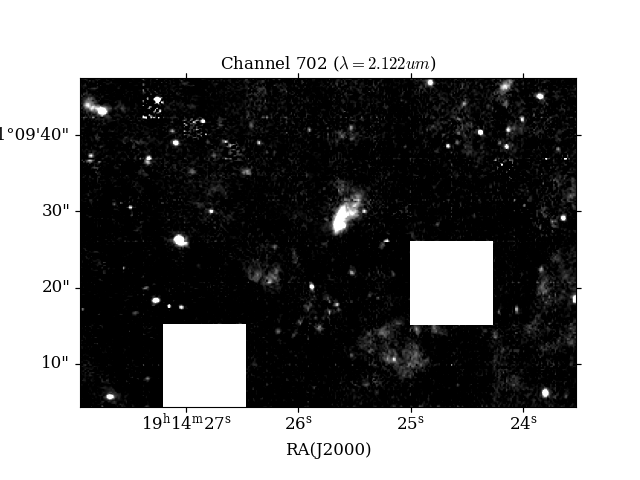

In [9]:
channel_plot(master_cube, 702, 0.5*10e-18)

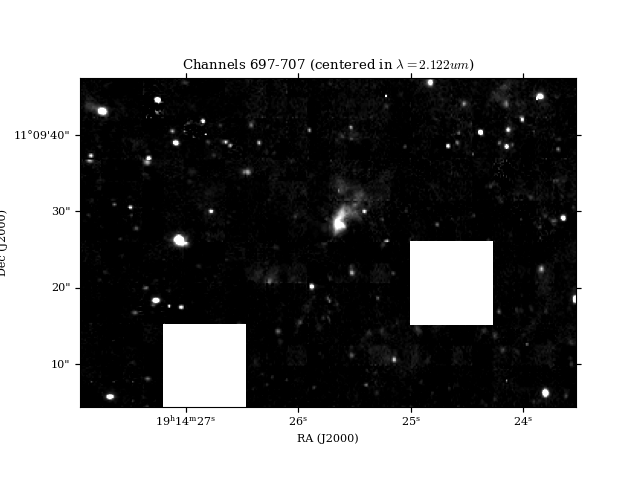

In [10]:
some_channels_plot(master_cube, 697, 707,  5*10e-18)

In [11]:
# I'll choose the subknot K1a (see the thesis uploaded to UGR's repository called 
# "NIR Observations of Massive Protostellar Outflows") to extract an spectrum
# INFO of K1a:

# KNOT 1A
ll_vertex_knot1a = wcs_half2.celestial.world_to_pixel(SkyCoord(ra='19:14:25.73', dec='11:9:27', unit=(u.hourangle, u.deg)))
ur_vertex_knot1a = wcs_half2.celestial.world_to_pixel(SkyCoord(ra='19:14:25.54', dec='11:9:31', unit=(u.hourangle, u.deg)))

center_knot1a_x = (ll_vertex_knot1a[0] + ur_vertex_knot1a[0]) / 2
center_knot1a_y = (ll_vertex_knot1a[1] + ur_vertex_knot1a[1]) / 2

side_knot1a_x = ur_vertex_knot1a[0] - ll_vertex_knot1a[0] 
side_knot1a_y = ur_vertex_knot1a[1] - ll_vertex_knot1a[1] 

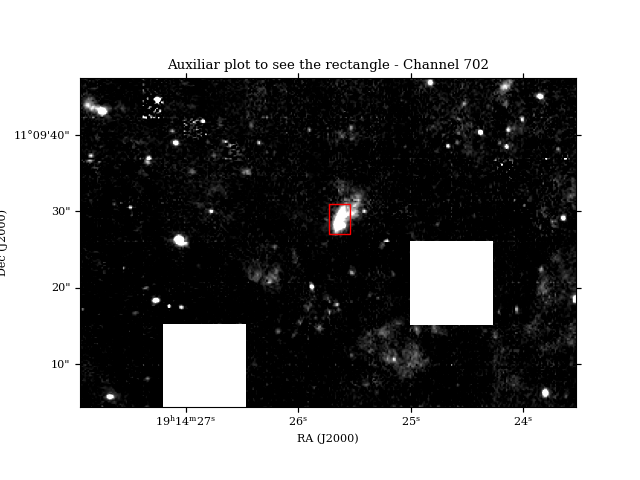

C:\Users\pablo\AppData\Local\Temp\ipykernel_23248\3715142000.py:24: RuntimeWarning: All-NaN slice encountered
  spect.append(np.nanmedian(rect_cube[a, :, :]))


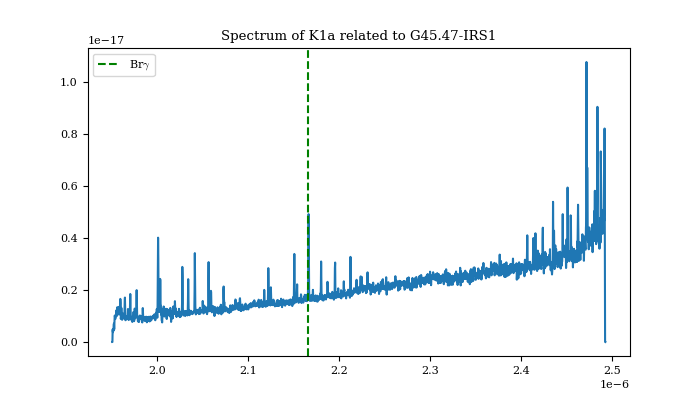

In [12]:
spect_k1a = spectroscopy_showing_rectangle(master_cube, center_knot1a_x, center_knot1a_y, side_knot1a_x, side_knot1a_y, 0.5*10e-18)

plt.figure(figsize=(7, 4)) 
plt.title(f'Spectrum of K1a related to G45.47-IRS1')
plt.plot(wcs_half2.spectral.pixel_to_world(np.array(range(2048))).value, spect_k1a)
plt.axvline(2.1655*10**(-6), color='g', linestyle='--', label=r'Br$\gamma$')
plt.legend()

# Continuum-Subtraction

### Choosing continuum channels

In [13]:
# In the next list the even position values are the start of an interval and the odd ones the end of each one
# These values may differ for different studies, in my case I've chosen these by seeing which channels have no emission in
# different stars and jet-knots
cont_intervals = np.array([1.954, 1.9552, 1.98, 1.9934, 2.02, 2.024, 2.0434, 2.0535, 2.0777, 2.115,
                 2.1277, 2.1475, 2.1579, 2.1629, 2.1707, 2.1759, 2.188, 2.1927, 
                2.235, 2.2883, 2.335, 2.34, 2.3983, 2.4041, 2.4255, 2.434, 2.458, 2.4610, 2.475, 2.48, 2.49, 2.491])*10**(-6)

cont_intervals_channel = wcs_half2.spectral.world_to_pixel(SpectralCoord(cont_intervals, unit='m'))

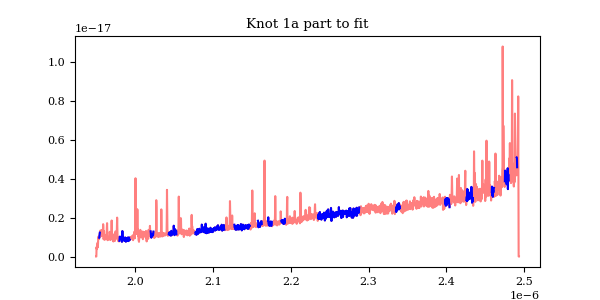

In [14]:
spect_to_fit = []
spect_to_take =  spect_k1a
for i in range(2048):
        # Inicialise NaN by default
        fit_value = np.nan
        # Verify wether i is within any interval or not
        for j in range(0, len(cont_intervals_channel), 2): 
            if cont_intervals_channel[j] <= i <= cont_intervals_channel[j + 1]:
                fit_value = spect_to_take[i]
                break  # Once it is found in an interval, there is no need of keep searching
        spect_to_fit.append(fit_value)

plt.figure(figsize=(6, 3)) 
plt.title(f'Knot 1a part to fit')
plt.plot(wcs_half2.spectral.pixel_to_world(np.array(range(2048))).value, spect_k1a, alpha=0.5, color='red') # Full spectrum
plt.plot(wcs_half2.spectral.pixel_to_world(np.array(range(2048))).value, spect_to_fit, color='blue')        # Continuum channels

### Chosing function to fit the continuum

(0.0, 5e-18)

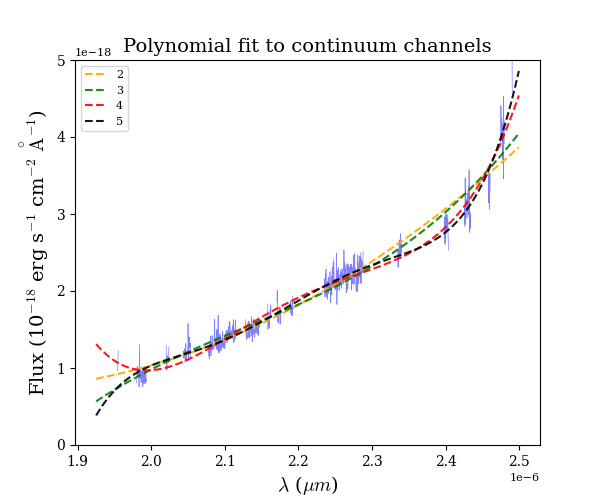

In [15]:
# FIT
spect_to_fit = np.array(spect_to_fit)
valid_indices = ~np.isnan(spect_to_fit)
x = wcs_half2.spectral.pixel_to_world(np.arange(len(spect_to_fit))[valid_indices]).value
y = spect_to_fit[valid_indices]

# Plynomial fitting ignoring NaN
polynomial_2 = np.poly1d(np.polyfit(x, y, 2))
polynomial_3 = np.poly1d(np.polyfit(x, y, 3))
polynomial_4 = np.poly1d(np.polyfit(x, y, 4))
polynomial_5 = np.poly1d(np.polyfit(x, y, 5))

# Making fitting points
x_fit = wcs_half2.spectral.pixel_to_world(np.arange(len(spect_to_fit))).value
y_fit_2 = polynomial_2(x_fit)
y_fit_3 = polynomial_3(x_fit)
y_fit_4 = polynomial_4(x_fit)
y_fit_5 = polynomial_5(x_fit)

plt.figure(figsize=(6, 5))
plt.plot(wcs_half2.spectral.pixel_to_world(np.array(range(2048))).value, spect_to_fit, color='blue', lw=0.5, alpha=0.5)
plt.ylim(0, 10e-18)
plt.title('Polynomial fit to continuum channels', fontsize=14)
plt.plot(x_fit, y_fit_2, color='orange', label='2', alpha=0.9,  linestyle='--')
plt.plot(x_fit, y_fit_3, color='g', label='3', alpha=0.9, linestyle='--')
plt.plot(x_fit, y_fit_4, color='red', label='4', alpha=0.9, linestyle='--')
plt.plot(x_fit, y_fit_5, color='black', label='5', alpha=0.9, linestyle='--')
plt.xlabel(r'$\lambda$ ($\mu m$)', fontsize=14)
plt.ylabel(r'Flux (10$^{-18}$ erg s$^{-1}$ cm$^{-2}$ $\overset{\circ}{\text{A}}^{-1}$)', fontsize=14)
plt.tick_params(axis='both', labelsize=10)
plt.legend()
plt.ylim(0, 0.5e-17)

### Making the continuum-subtracted cube

In [16]:
# If we already have a continuum-subtracted cube, we retrieve it

master_cube_continuum_substracted = fits.open('C:\\Users\\pablo\\Desktop\\TFM\\data\\master_cube_substracted.fits')[0].data

### Continuum Image

In [17]:
def continuum_image(master_cube, cont_intervals_channel, vmax):
    # cont_intervals_channel must be an array/list where the odd positions corresponds to the starting channels of the 
    # continuum intervals and the even ones to the ending channels of them
    # Some auxiliary calcs
    partial_continuum_images = []
    for i in range(int(len(cont_intervals_channel)/2)):
        sum_of_channels = np.nansum(master_cube[int(cont_intervals_channel[2*i]):int(cont_intervals_channel[2*i+1])], axis=0)
        partial_continuum_images.append(sum_of_channels)
    
    continuum_sum = np.sum(partial_continuum_images, axis=0)
    

    continuum_sum_recolored = continuum_sum.copy()
    continuum_sum_recolored[continuum_sum_recolored==0] = np.nan

    
    # Make the plot
    plt.figure()
    ax = plt.subplot(projection=wcs_half2.celestial) 
    #ax.contour(imagesSO[3], transform=ax.get_transform(wSO), levels=levels_SO37, colors='cyan')
    plt.imshow(continuum_sum_recolored, origin='lower', cmap='gist_gray', vmin=0, vmax=vmax*10)
    plt.title(rf'Continuum Cube')
    plt.ylabel('Dec (J2000)')
    plt.xlabel('RA (J2000)')
    plt.show()
    
    return continuum_sum_recolored

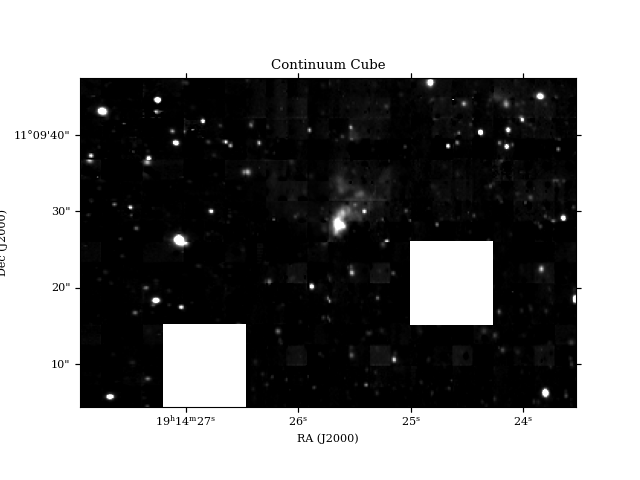

array([[-1.46373553e-16, -1.04793096e-16, -1.90404444e-16, ...,
         1.32143320e-16, -1.20792828e-16, -1.55988251e-16],
       [-1.47761139e-16, -1.20643869e-16, -9.45500726e-17, ...,
         1.08474077e-16, -1.31459209e-16, -7.95498801e-17],
       [-1.53492032e-16, -1.05418902e-16, -5.53696339e-17, ...,
         5.43110975e-17, -9.28312442e-17, -5.00449333e-17],
       ...,
       [ 7.60016128e-17,  7.85311311e-17,  1.73502986e-17, ...,
        -2.38438981e-16, -1.78157909e-16, -1.70596194e-16],
       [ 9.40328862e-17, -6.52561751e-18,  3.68003589e-17, ...,
        -3.75954700e-16, -4.23320147e-16, -3.33275939e-16],
       [ 7.39579274e-17,  1.28682561e-17, -1.47545877e-17, ...,
        -3.16272335e-16, -4.27903601e-16, -7.87628568e-16]], dtype=float32)

In [18]:
continuum_image(master_cube, cont_intervals_channel, 3*10e-17)